In [172]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)

from parallel import Invoker

In [173]:
# Calculate params for simulations
from numpy import arange,linspace,logspace
NUM_SIMULATED_CORES = 16
F_STEP = 2
FunctionRange = arange(2,NUM_SIMULATED_CORES+F_STEP,F_STEP) # interval is open
#FunctionRange = [8]
GroupingRange = logspace(base=2,start=0,stop=4,num=5)

import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
            
def filter_configs_by_cores(num_funcs,grouping,divisor_list):
    num_queues = num_funcs / grouping
    if num_queues in divisor_list:
        return True
        return (num_funcs,grouping,cores_per_q)
    
# Cores_per_q is always even for now by virtue of filter_configs_by_cores
def setup_final_config(num_funcs,grouping):
    num_queues = num_funcs / grouping
    cores_per_q = NUM_SIMULATED_CORES / num_queues
    return { 'funcs': int(num_funcs), 'grouping' : int(grouping), 'cores_per_q': int(cores_per_q)}
    
core_divisors = list(divisorGenerator(NUM_SIMULATED_CORES))
iterator_combinations = ((fr,gr) for fr in FunctionRange for gr in GroupingRange )
possible_combos = filter(lambda x : filter_configs_by_cores(x[0],x[1],core_divisors), iterator_combinations)
final_params = list(map(lambda x : setup_final_config(x[0],x[1]), possible_combos)) # don't run this cell repeatedly

In [ ]:
#### Run simulations for various function numbers and various function grouping
def setup_sim(func_group,core_group,num_functions,load_range):
    invokerArgs = {'runnableTarg' : 'qmodel_dispatch',
                  'mode': 'sweep_A',
                  'numProcs' : os.cpu_count(),
                  'NumWorkers' : NUM_SIMULATED_CORES,
                   'argrange': load_range,
                   'NumFunctions': num_functions,
                   'FunctionGrouping': func_group,
                   'CoreGrouping': core_group,
                   'RequestsToSimulate': 1000000
                  }
    return invokerArgs

import pandas
# Return a pandas dataframe with all results
def run_sims(func_group,core_group,num_functions,load_range):
    args = setup_sim(func_group,core_group,num_functions,load_range)
    simulationController = Invoker( **args )
    simulationController.startProcs()
    simulationController.joinProcs()
    # Get results
    numProcs = args['numProcs']
    
    results = [ simulationController.getResultsFromQueue(idx) for idx in range(numProcs) ]
    flat_results = [ y for x in results for y in x ]
    
    # Remap results to the following format to import to pandas
    # { 'loads' : [ list of data points ]
    #    <Percentile Value> : [ list of data points ]
    # }
    def add_key_or_append(d,k,v):
        if k in d.keys():
            d[k].append(v)
        else:
            d[k] = []
            
    remap_dict = {}
    
    for x in flat_results:
        for load,times in x.items():
            load_mrps = 1/(load*1e-9)/1e6
            remap_dict[load_mrps] = times
    sorted_dict = {k:v for k,v in sorted(remap_dict.items(),key=lambda x : x[0])}
    f_dict = {}
    
    for load,time_dict in sorted_dict.items():
        # Append all loads to dict
        add_key_or_append(f_dict,'load',load)
        for p,v in time_dict.items():
            add_key_or_append(f_dict,str(p),v)      

    return args,pandas.DataFrame.from_dict(f_dict)

from numpy import linspace
### Run a group of simulations for each pair of num_functions/function_groupings
load_range = linspace(100,1000,40)
#args,ex_df = run_sims(4,4,16,load_range)
sims_gen = list(map(lambda x : run_sims(x['grouping'],x['cores_per_q'],x['funcs'],load_range),final_params))

LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')
LoadGenerator killed by feedback with Simpy text: Interrupt('end of sim')


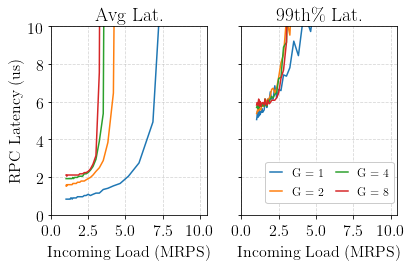

In [171]:
####### Create 50th and 99th% plots for various G
graph_us = {}
for args,df in sims_gen:
    graph_us[args['FunctionGrouping']] = df

#percentiles = ['50','95','99','99.9']
#for grouping,df in graph_us.items():
#    for p in percentiles:
#        graph_us[grouping][p] = graph_us[grouping][p].multiply(1000)
        
#print(graph_us)
    
# Generate plots
import matplotlib.pyplot as plt
import numpy
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
fontdir = {'size':16,'family':'serif'}
rc('font',**fontdir)
rc('text',usetex=True)

fname = 'grouping_comparisons_'+str(NUM_SIMULATED_CORES)+'funcs.pdf'
if os.path.exists(fname):
    print('Figure already exists with fname',fname,'will back up!')
    fname_bak = fname + '.bak'
    os.rename(fname,fname_bak)

with PdfPages('grouping_comparisons_16funcs.pdf') as pp:
    f,axarr = plt.subplots(1,2)
    for series, values in graph_us.items():
        l = 'G = ' + str(series)
        values.plot(x='load',y='50',ax=axarr[0],label=l)
        values.plot(x='load',y='99',ax=axarr[1],label=l)

    for i,ax in enumerate(axarr):
        ax.grid(True,axis='both',linestyle='--',alpha=0.5)
        ax.get_legend().remove()
    
    
    handles, labels = axarr[0].get_legend_handles_labels()


    axarr[0].set_ylabel('RPC Latency (us)')
    axarr[0].set_xlabel('Incoming Load (MRPS)')
    axarr[1].set_xlabel('Incoming Load (MRPS)')
    axarr[0].set_ylim(0,10)
    axarr[0].set_xticks(numpy.linspace(0,10,5))
    axarr[1].set_xticks(numpy.linspace(0,10,5))
    axarr[0].set_title('Avg Lat.')
    axarr[1].set_title('99th\% Lat.')

    f.legend(handles,labels,loc='lower left',bbox_to_anchor=(0.6,0.2),ncol=2,fontsize=12,frameon=True,framealpha=1,
        handlelength=1,columnspacing=1)
    
    f.tight_layout()
    pp.savefig()